In [1]:
import numpy as np
import pandas as  pd
import tensorflow as tf
from tensorflow import keras
#import keras
import matplotlib.pyplot as plt 
from tensorflow.keras import layers
from sklearn import *
import math
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
plt.rcParams["figure.figsize"] = (20,10)
tf.autograph.set_verbosity(0)


In [2]:
from ipynb.fs.defs.UtilitiesVED import *


## Import Data


In [96]:
mpc = 640


In [103]:

data =  pd.read_csv("../../Data/data_UE1_600/data_unfold_UE1_600.csv", index_col=0)

data = data.values


(590, 2560)
(590, 2560)


### Subsetting 2 subbands

In [99]:
 590*0.4

236.0

In [109]:
X = data[:,:mpc*4]
y = data[:,:mpc*4]
print(X.shape)
print(y.shape)


(590, 2560)
(590, 2560)


In [110]:
X_train = X[:-236, :mpc*2]
y_train = y[:-236, (mpc*2):]

X_test =  X[-236:, mpc*2:]
y_test =  y[-236:, (mpc*2):]

In [111]:
print(X_test.shape)
print(y_test.shape)

print(X_train.shape)
print(y_train.shape)

(236, 1280)
(236, 1280)
(354, 1280)
(354, 1280)


In [113]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_esc = scaler.transform(X_train)
X_test_esc = scaler.transform(X_test)


## Create a sampling layer


## Build the encoder


In [122]:
latent_dim = 100 # Latent Space dimension on the bottleneck
input_dim = X_train.shape[1]
ReLu = keras.layers.ReLU()

encoder_inputs = keras.Input(shape=( input_dim, ))
x = layers.Dense(mpc, activation=ReLu)(encoder_inputs)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 1280)]       0           []                               
                                                                                                  
 dense_14 (Dense)               (None, 640)          819840      ['input_10[0][0]']               
                                                                                                  
 z_mean (Dense)                 (None, 100)          64100       ['dense_14[0][0]']               
                                                                                                  
 z_log_var (Dense)              (None, 100)          64100       ['dense_14[0][0]']               
                                                                                            

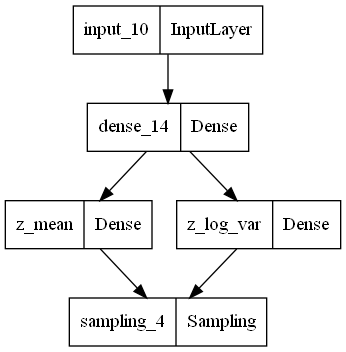

In [123]:
from keras.utils.vis_utils import plot_model
keras.utils.plot_model(encoder, to_file='encoder.png')

## Build the decoder


In [131]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(50,  activation=ReLu)(latent_inputs)
decoder_outputs = layers.Dense(mpc*2, activation="linear")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 100)]             0         
                                                                 
 dense_19 (Dense)            (None, 50)                5050      
                                                                 
 dense_20 (Dense)            (None, 1280)              65280     
                                                                 
Total params: 70,330
Trainable params: 70,330
Non-trainable params: 0
_________________________________________________________________


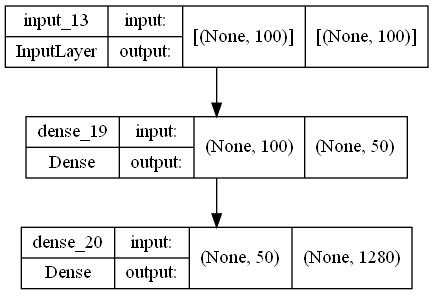

In [132]:
plot_model(decoder,  show_shapes=True, show_layer_names=True)

## Define the VAE as a Model with a custom train_step


## Train the VAE

In [133]:
vae = VAE(encoder, decoder, 1)

In [134]:
vae.compile(optimizer=keras.optimizers.Adam())

In [135]:
es = keras.callbacks.EarlyStopping(
    monitor="MSE",
    patience=4,
)

In [136]:
history = vae.fit(X_train_esc, y_train, validation_data=(X_test_esc , y_test), epochs=40, batch_size=20)

Epoch 1/40
18/18 [==============================] - 2s 32ms/step - loss: 54.0176 - MSE: 0.0678 - kl_loss: 39.1120 - val_loss_val: 71.3459 - val_MSE_val: 0.0670 - val_kl_loss_val: 70.9825
Epoch 2/40
18/18 [==============================] - 0s 14ms/step - loss: 18.6076 - MSE: 0.0376 - kl_loss: 16.7856 - val_loss_val: 65.7206 - val_MSE_val: 0.0475 - val_kl_loss_val: 65.4124
Epoch 3/40
18/18 [==============================] - 0s 15ms/step - loss: 10.6304 - MSE: 0.0283 - kl_loss: 9.9284 - val_loss_val: 61.6588 - val_MSE_val: 0.0362 - val_kl_loss_val: 61.3428
Epoch 4/40
18/18 [==============================] - 0s 15ms/step - loss: 6.9620 - MSE: 0.0232 - kl_loss: 6.5061 - val_loss_val: 58.6869 - val_MSE_val: 0.0290 - val_kl_loss_val: 58.3600
Epoch 5/40
18/18 [==============================] - 0s 15ms/step - loss: 4.7816 - MSE: 0.0199 - kl_loss: 4.5977 - val_loss_val: 56.8500 - val_MSE_val: 0.0257 - val_kl_loss_val: 56.5534
Epoch 6/40
18/18 [==============================] - 0s 15ms/step - los

In [137]:
def nrmse(y_pred, y_test):
    
    num = tf.math.reduce_sum(tf.square(y_pred - y_test))
    num = num / y_test.shape[1]
    
    den = tf.math.reduce_sum(tf.square(y_test))/y_test.shape[1]
    
    return (num/den).numpy()

def mse(y_pred, y_test):
    
    num = tf.math.reduce_sum(tf.square(y_pred - y_test))
    num = num / y_test.shape[1]
    
    return num.numpy()

def mae(y_pred, y_test):
    
    num = tf.math.reduce_sum(tf.abs(y_pred - y_test))
    num = num / y_test.shape[1]
    
    return num.numpy()

print('NRMSE', nrmse(vae.predict(X_test), y_test))
print('MAE', mae(vae.predict(X_test), y_test))
print('RMSE', math.sqrt(mse(vae.predict(X_test), y_test)))
print('MSE', mse(vae.predict(X_test), y_test))


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x000001C00F87F820>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
NRMSE 1.0399099880765132
MAE 12.218271306983254
RMSE 1.6723629690492239
MSE 2.80924725300194


# PLOTS


In [138]:
samp_num = 1

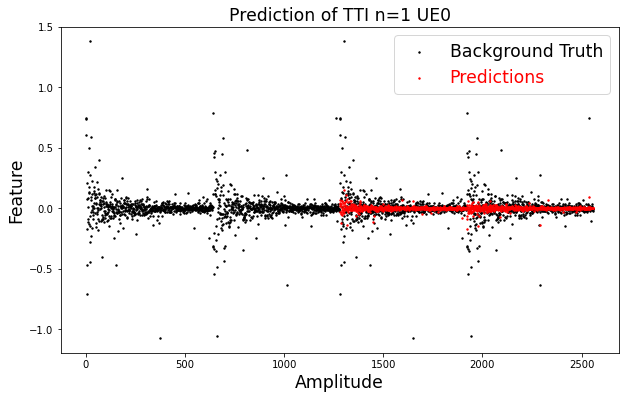

In [139]:
plt_1 = plt.figure(figsize=(10, 6))
sample_1 = np.r_[ y_test[samp_num,], X_test[samp_num,]]
idx = np.arange(len(sample_1))
plt.scatter(np.arange(len(sample_1)), sample_1, s=2, c="black")
plt.scatter(idx[-len(vae.predict(X_test)[samp_num,]):], vae.predict(X_test)[samp_num,], color='red',  s=2)
plt.title('Prediction of TTI n={} UE0'.format(samp_num) , fontsize ='xx-large')
plt.legend(['Background Truth', 'Predictions'],labelcolor = ['black', 'red'] ,loc='upper right', fontsize ='xx-large')
plt.ylabel('Feature', fontsize ='xx-large')
plt.xlabel('Amplitude', fontsize ='xx-large')

plt.show()

In [140]:
print(history.history.keys())

dict_keys(['loss', 'MSE', 'kl_loss', 'val_loss_val', 'val_MSE_val', 'val_kl_loss_val'])


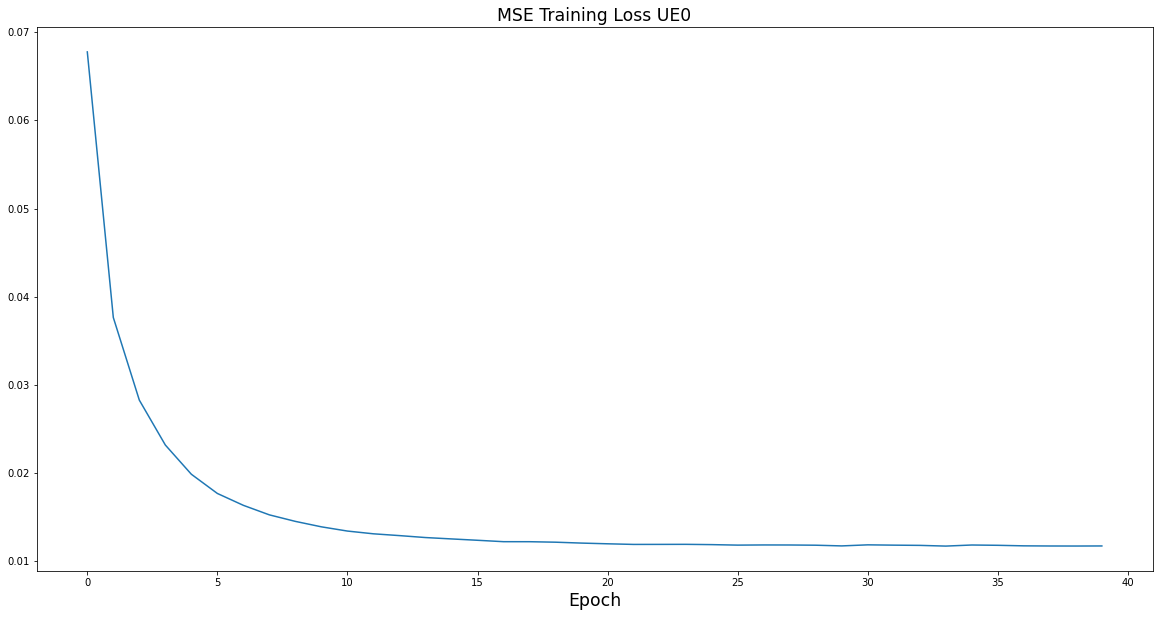

In [141]:
plt.plot(history.history['MSE'])
plt.title('MSE Training Loss UE0', fontsize ='xx-large')
plt.xlabel('Epoch', fontsize ='xx-large')
plt.show()

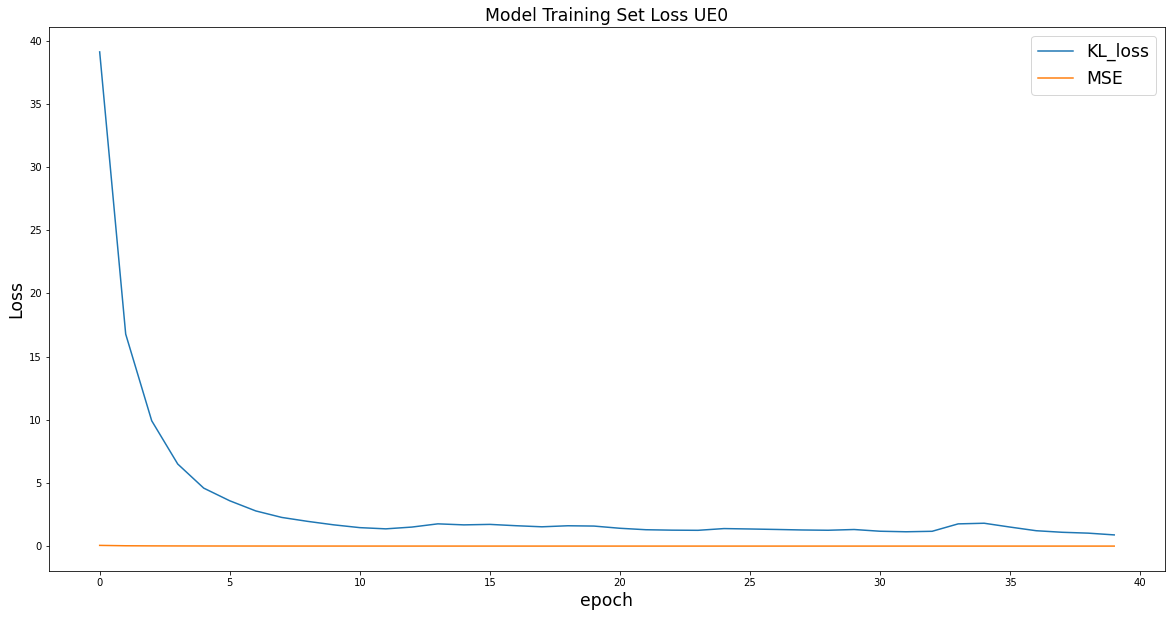

In [142]:
plt.plot(history.history['kl_loss'])
#plt.plot(history.history['val_total_loss'])
plt.title('Model Training Set Loss UE0', fontsize ='xx-large')
plt.ylabel('Loss', fontsize ='xx-large')
plt.xlabel('epoch', fontsize ='xx-large')
plt.plot(history.history['MSE'])
plt.legend(['KL_loss', 'MSE'], loc='upper right', fontsize ='xx-large')
plt.show()


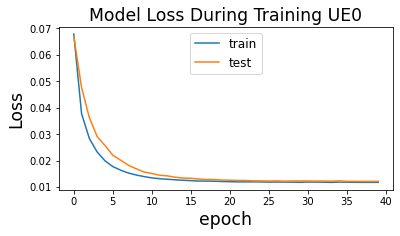

In [153]:
# summarize history for accuracy
plt_1 = plt.figure(figsize=(6, 3))

plt.plot(history.history['MSE'])
#plt.plot(history.history['val_total_loss'])
plt.ylabel('Loss', fontsize ='xx-large')
plt.xlabel('epoch', fontsize ='xx-large')
plt.plot(history.history['val_MSE_val'])

plt.legend(['train', 'test'], loc='upper center', fontsize ='12')
plt.title('Model Loss During Training UE0', fontsize='xx-large')

plt.show()


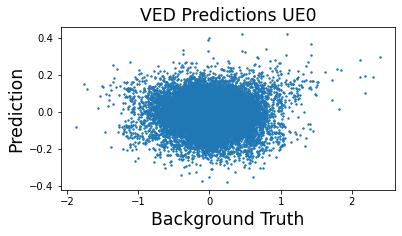

In [154]:
plt_1 = plt.figure(figsize=(6, 3))
plt.scatter(y_test.flatten(), vae.predict(X_test_esc).flatten(), s=2)
plt.title('VED Predictions UE0', fontsize='xx-large')
plt.ylabel('Prediction', fontsize ='xx-large')
plt.xlabel('Background Truth', fontsize ='xx-large')

plt.show()

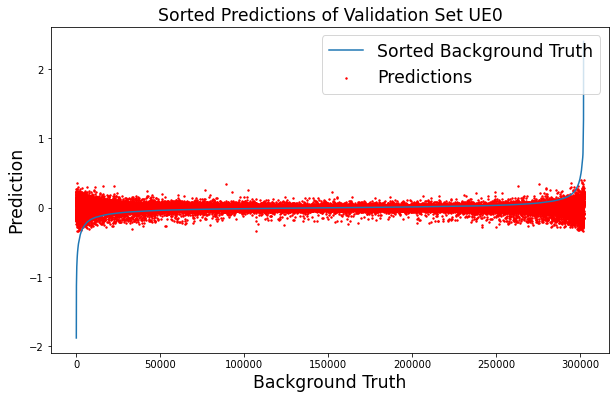

In [155]:
plt_1 = plt.figure(figsize=(10, 6))

plt.plot(np.sort(y_test.flatten()))
x_idx = np.arange(len(y_test.flatten()))
plt.scatter(x_idx, vae.predict(X_test_esc).flatten()[np.argsort(y_test.flatten())], s=2, c="red")

plt.title('Sorted Predictions of Validation Set UE0', fontsize='xx-large')
plt.ylabel('Prediction', fontsize ='xx-large')
plt.xlabel('Background Truth', fontsize ='xx-large')
plt.legend(['Sorted Background Truth', 'Predictions'], loc='upper right', fontsize ='xx-large')

plt.show()


# 

# Reconstruct the validation set

In [148]:
y_pred = vae.predict(X_test)

y_pred.shape


(236, 1280)

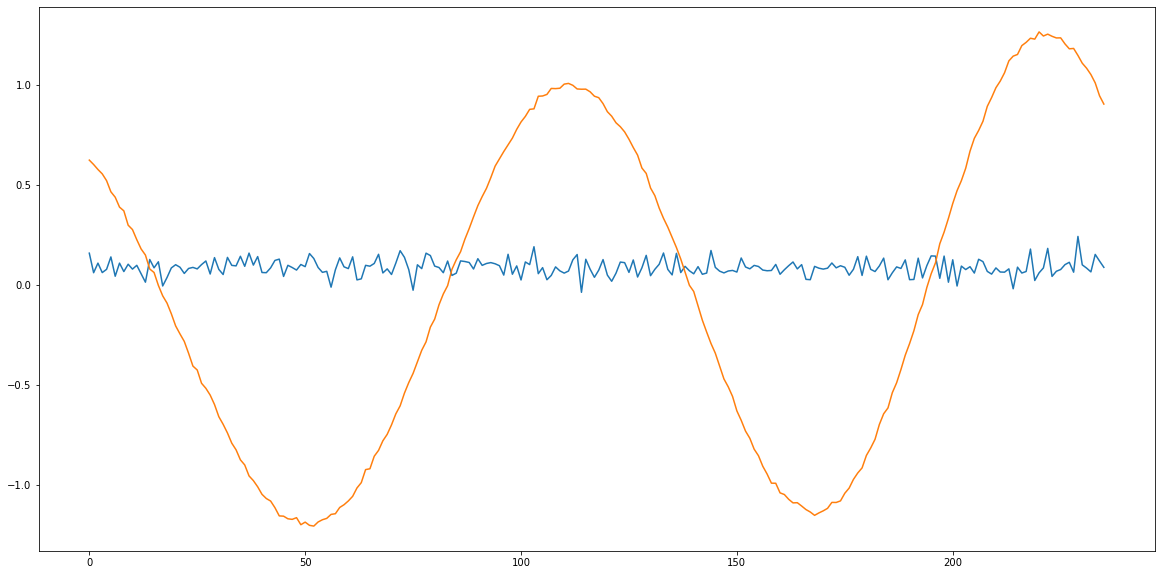

In [158]:
plt.plot(y_pred[:,0])
plt.plot(y_test[:,0])
